In [43]:
Prob = 21
lamda = 1.8

In [44]:
import time
start_time = time.time()
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import *
from copy import deepcopy
from decimal import*
np.set_printoptions(0)
import pprint

problem = np.array(['P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32'])
Acase = np.array([40, 60, 40, 40, 76, 40, 84, 40, 40, 40, 40, 40])
Bcase = np.array([14, 10, 16, 18, 10, 20, 10, 22, 24, 26, 28, 30])
capacity_case = np.array([1200, 900, 1400, 1500, 900, 1700, 900, 1800, 2000, 2100, 2300, 2500])
maxrl_case = np.array([1800, 1000, 2200, 2400, 900, 2500, 900, 2800, 3000, 3200, 3500, 3600])
Target_Case = np.array([16212.83, 14641.64, 18801.13, 21389.43, 17053.26, 23977.74, 17651.6, 26566.04, 29154.34, 31742.64, 34330.94, 36919.24])

def Problem(PXX):
    PXX = 'P'+str(PXX)
    pindex = list(problem).index(PXX)
    a = Acase[pindex]
    b = Bcase[pindex]
    c = capacity_case[pindex]
    mrl = maxrl_case[pindex]
    tg = Target_Case[pindex]
    return a, b, c, mrl, tg

## Problem Generator

In [45]:
def generator(A, B):
    '''
    Generates points for the problem set.
    Customers = A*B
    A = Customers around depot
    B = Customers in line 
    '''
    w = 0
    n = A*B
    print(f'{n} customers')
    x = np.empty([n+1, 1])[:,0]
    y= np.empty([n+1, 1])[:,0]
    q= np.empty([n+1, 1])[:,0]
    
    x[0] = 0
    y[0] = 0
    q[0] = 0

    for k in range(1, B+1):
        gamma = 30*k
        for i in range(1, A+1):
            w = w + 1
            x[w] = gamma*np.cos((2*(i-1)*np.pi)/A)
            y[w] = gamma*np.sin((2*(i-1)*np.pi)/A)
            
            if np.mod(i, 4) == 2 or np.mod(i, 4) == 3:
                q[w] = 30
            else:
                q[w] = 10
    return x, y, q

def route(a, b):
    ''' Calculates route length between point a and b'''
    x0, y0 = a
    xf, yf = b
    
    distance = np.sqrt((yf-y0)**2 + (xf-x0)**2)
    return distance
    
def locationlist(val):
    #lim = len(max(pathroute, key = len))
    #print(lim)
    for getn in range(0,len(filterrm(pathroute))):
        #print(lim, getn)
        try:
            i = pathroute[getn].index(val)
            to_n = getn
            to_i = i
            #print(ton, toi)
        except ValueError:
            getn += 1 
    return to_n, to_i

def routedistance(routemap):
    distance = [[0] for _ in range(xi.shape[0])]
    for n in range(len(routemap)):
        if len(routemap[n])>2:
            distance[n] = 0
            for index in range(len(routemap[n])-1):
                    distance[n]+= cij[routemap[n][index]][routemap[n][index + 1]]
    return distance

def obj_UB(routemap):
    d = routedistance(routemap)
    UB = np.sum(d)
    return UB

def calcdemand(routemap):
    demand = [[0] for _ in range(len(filterrm(routemap)))]
    for n in range(len(filterrm(routemap))):
        for index in range(len(routemap[n])):
            demand[n] += qi[routemap[n][index]]
            #print(n)
    return demand

def demandpath(path):
    demand = 0
    for index in range(len(path)):
        demand += qi[path[index]]
    return demand

def pathdistance(path):
    dist = 0
    for index in range(len(path)-1):
        dist += cij[path[index]][path[index+1]]
    return dist

In [46]:
def connected(index_i):
    for j in range(0, xi.shape[0]):
        if flag[index_i, j]==1:
            index_i = j
            return index_i

def path(flagmatrix):
    '''
    Converts flag matrix to route list
    '''
    pathroute = [[0] for _ in range(xi.shape[0])]

    for j in range(1, xi.shape[0]):
        if flagmatrix[0, j] == 1:
            pathroute[j].append(j)
            to = j
            while(to!=0):
                to = connected(to)
                pathroute[j].append(to)
    return pathroute

def updatesavings(index_maxij):
    i, j = index_maxij
    #if flag[0,i] == 1 or flag[i,0]==1 or flag[j,0]==1 or flag[0,j]==1:
    flag[i, j] = 1
    flag[0, j] = 0
    flag[i, 0] = 0
    i_sij[i] = 0
    i_sij[:, j] = 0
    sij[i, j] = 0
    #plotroute(flag)
    return i_sij, sij

def filterrm(routemap):
    answer = []
    for n in range(len(routemap)):
        if sum(routemap[n])!=0:
            answer.append(routemap[n])
    return answer

def flagmap(routemap):
    flag = np.zeros(np.array([xi.shape[0],xi.shape[0]]))
    for n in range(len(routemap)):
        if np.sum(routemap[n]) !=0:
            row = len(routemap[n])

            for j in range(row-1):
                fi = routemap[n][j]
                fj = routemap[n][j+1]
                flag[fi][fj] = 1
                #print(routemap[n][j], routemap[n][j+1])
    
    #print(flag)
    return flag

def plotroute(flagmap):
    plt.plot(xi, yi, 'g.')
    for i in range(xi.shape[0]):
        for j in range(i, xi.shape[0]):
            if flagmap[i,j] == 1: # 0 to j
                plt.plot(np.array([xy[i][0], xi[j]]), np.array([xy[i][1], yi[j]]), 'r') # i to j
    for i in range(0, xi.shape[0]):
        for j in range(0, i):
            if flagmap[i,j] == 1: # j to 0
                plt.plot(np.array([xy[j][0], xi[i]]), np.array([xy[j][1], yi[i]]), 'b--') # j to i
                #print(i, j)            

def plotpath(routemap):
    print('P', Prob)
    print('$\lamda$ = ', lamda)
    print(A, 'x', B, ':',A*B, 'Customers')
    print('Route Distance: ',sum(routedistance(routemap)))
    print('Best Known ', T)
    plt.plot(xi, yi, 'r.')
    for i in range(len(filterrm(routemap))):
        #for j in range(len(routemap[i]) - 1):
            plt.plot(xi[routemap[i]], yi[routemap[i]], lw = 3)
            
def success(routemap):
    repeat = 0
    rl = 0
    dl = 0
    for pathn in range(len(filterrm(routemap))):
        for point in range(xi.shape[0]):
            occurrences = filterrm(routemap)[pathn].count(point)
            if occurrences > 1 and point != 0:
                print(point, "-",occurrences,"times")
            else:
                repeat += 1
                #print(repeat)
                break
        if demandL[pathn] != MAXC - calcdemand(routemap)[pathn]:
            print('Fail', pathn)
        else:
            dl += 1
            #print(rl)
        if abs(distance[pathn] - routedistance(routemap)[pathn]) > 1e-3:
            print('Fail', pathn)
        else:
            rl += 1
            #print(dl)
    print('---Report---')    
    
    x = len(filterrm(routemap))
    
    if repeat == x:
        print('Repeat - Pass')
    else:
        print('Repeat - Fail')        
        
    if rl ==  x:
        print('Distance - Pass')
    else:
        print('Distance - Fail')

    if dl == x:
        print('Demand = Pass')
    else:
        print('Demand = Fail')        

<h3>Problem Raw Data Visualization</h3>

560 customers


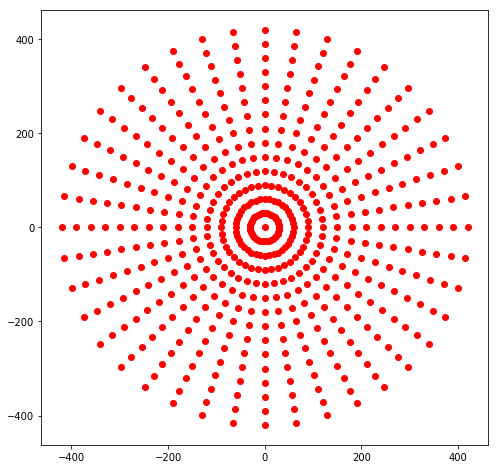

(40, 14, 1800, 1200)

In [47]:
A, B, MAXC, MAXR, T = Problem(Prob)
P = generator(A, B)
xi = P[0]
yi = P[1]
xy = np.array(list(zip(xi,yi)))
plt.figure(figsize = (8,8))
plt.plot(xi, yi, 'ro')
plt.show()
qi = P[2]
A,B, MAXR, MAXC

In [48]:
# Distance cost matrix
cij = np.zeros([xi.shape[0], xi.shape[0]])
for i in range(0, xi.shape[0]):
    for j in range(0, xi.shape[0]):
        cij[i,j] = (route(np.array([xi[i],yi[i]]), np.array([xi[j], yi[j]])))
cij, qi

(array([[  0.,  30.,  30., ..., 420., 420., 420.],
        [ 30.,   0.,   5., ..., 394., 392., 390.],
        [ 30.,   5.,   0., ..., 396., 394., 392.],
        ...,
        [420., 394., 396., ...,   0.,  66., 131.],
        [420., 392., 394., ...,  66.,   0.,  66.],
        [420., 390., 392., ..., 131.,  66.,   0.]]),
 array([ 0., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10.,
        10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10.,
        30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30.,
        30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30.,
        10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10.,
        10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10.,
        30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30.,
        30., 10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30.,
        10., 10., 30., 30., 10., 10., 30., 30., 10., 10., 30., 30., 10.,
        10., 30., 30.,

In [49]:
#Rstep = 30
#Lij = np.zeros([xi.shape[0], xi.shape[0]])
#for i in range(1, xi.shape[0]):
#    ringi = ((i-1)//A)+1
#    linei = ((i-(ringi-1)*A))
#    for j in range(0, xi.shape[0]):
#        ringj = ((j-1)//A)+1
#        linej = ((j-(ringj-1)*A))
#        #print(linej, j)
#        if ringi == ringj:
            
def msavings(Lamda):
    '''
    Calculates initial Savings Matrix
    '''
    sij = np.zeros([xi.shape[0], xi.shape[0]])
    for i in range(1, xi.shape[0]):
        ringi = ((i-1)//A)+1
        linei = ((i-(ringi-1)*A))
        coi = route(xy[0], xy[i])
        for j in range(i+1, xi.shape[0]):
            ringj = ((j-1)//A)+1
            linej = ((j-(ringj-1)*A))
            coj = route(xy[0], xy[j])
            cij = route(xy[i], xy[j])
            
            if linei ==linej:
                if ringi<=B/2 and ringj<=B/2:
                    Lamda = 0.8*Lamda
                else:
                    Lamda = lamda
            sij[i][j] = coi + coj - Lamda*cij + 0.2*np.abs(coi - coj)
            
            #print(i, j)
    return sij

master_sij = msavings(lamda)
sij = deepcopy(master_sij)
i_sij = deepcopy(master_sij)
print(master_sij)
c_sij = np.zeros(sij.shape)

initCWSA = 0         

[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.   52. ... -180. -177. -175.]
 [   0.    0.    0. ... -185. -180. -177.]
 ...
 [   0.    0.    0. ...    0.  721.  603.]
 [   0.    0.    0. ...    0.    0.  721.]
 [   0.    0.    0. ...    0.    0.    0.]]


# Start Here

<H3>Clark and Wright Savings Algorithm</H3>

In [17]:
def savings(Lamda):
    '''
    Calculates initial Savings Matrix
    '''
    sij = np.zeros([xi.shape[0], xi.shape[0]])
    for i in range(1, xi.shape[0]):
        coi = route(xy[0], xy[i])
        for j in range(i+1, xi.shape[0]):
            coj = route(xy[0], xy[j])
            cij = route(xy[i], xy[j])
            sij[i][j] = coi + coj - Lamda*cij
            
            #print(i, j)
    return sij

master_sij = savings(lamda)
sij = deepcopy(master_sij)
i_sij = deepcopy(master_sij)
print(master_sij)
#c_sij = np.zeros(sij.shape)
#
#initCWSA = 0

[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.   52. ... -258. -255. -253.]
 [   0.    0.    0. ... -263. -258. -255.]
 ...
 [   0.    0.    0. ...    0.  721.  603.]
 [   0.    0.    0. ...    0.    0.  721.]
 [   0.    0.    0. ...    0.    0.    0.]]


In [50]:
pathroute = [[0,0] for _ in range(xi.shape[0])]
distance = [[0] for _ in range(xi.shape[0])]
demandL = [[MAXC] for _ in range(xi.shape[0])]
allp = list(np.arange(1, xi.shape[0]))
exteriorp = list(np.arange(1, xi.shape[0]))
connectedp = []
interiorp = []
depotp = []
anchorp = [p for p in range(0,xi.shape[0]) if cij[0,p] < 40 and cij[0,p]>0]
n = 0 # number of routes
#exteriorp, interiorp, connectedp, anchorp

In [51]:
flag = np.zeros(sij.shape)
flag[0] = 1
flag.T[0] = 1
flag[0,0] = 0
path(flag)
#routedistance(path(flag))
UB = obj_UB((path(flag)))
UB
#path(flag),np.sum(routedistance(path(flag)))

array([252000.])

### SKIP INITIAL SAVING STEP HERE ------

In [ ]:
## FLAG MATRIX
#initCWSA = 1
#path(flag)

In [ ]:
## Calculate max saving and connect points
#timeCW1s = time.time()
#def iCnW(i_sij):
#    '''
#    Clark & Wright Initial Saving Algorithm
#    '''
#    while(np.sum(i_sij != 0)):
#        
#        maxij = np.unravel_index(np.argmax(i_sij), i_sij.shape)
#        print(maxij, i_sij[maxij], np.argmax(i_sij))
#        tempd = cij[0, maxij[0]] + cij[maxij[0],maxij[1]] + cij[maxij[1],0]
#        if tempd <= MAXR:
#
#            i_sij, sij = updatesavings(maxij)
#
#            if maxij[0] in exteriorp and maxij[1] in exteriorp:
#                exteriorp.remove(maxij[0])
#                exteriorp.remove(maxij[1])
#                connectedp.append(maxij[0])
#                connectedp.append(maxij[1])
#                depotp.append(maxij[0])
#                depotp.append(maxij[1])
#            #if maxij[0] in connectedp and maxij[1] in connectedp:
#        #i_sij, sij, path(flag)
#    return flag
##timeCW1 = time.time() - timeCW1s   
##iCnW(i_sij)
#print(f'-----------Completed {timeCW1:1.3f}s-------------')

In [ ]:
#pathroute = path(flag)
#routedistance(pathroute)
#distance, pathroute, plotroute(flag)
#filterrm(pathroute)

In [ ]:
#def typepoints(routemap):
#    extp = []
#    intp = []
#    deptp = []
#    cnctp = []
#    
#    for n in range(len(routemap)):
#        if len(routemap[n]) > 2:
#            deptp.append(routemap[n][1])
#            deptp.append(routemap[n][-2])
#            cnctp.append(routemap[n][0])
#            cnctp.append(routemap[n][-1])
#            for index in range(2, len(routemap[n])-2):
#                #print (extp)
#                intp.append(routemap[n][index])
#                cnctp.append(routemap[n][index])
#    return extp, intp, deptp, cnctp
#typepoints(pathroute)
#exteriorp = typepoints(pathroute)[0]
#exteriorp

### TILL HERE --------------------

(481, 521) 762.0
Exterior
(482, 522) 762.0
Exterior
(484, 524) 762.0
Exterior
(485, 525) 762.0
Exterior
(486, 526) 762.0
Exterior
(487, 527) 762.0
Exterior
(488, 528) 762.0
Exterior
(489, 529) 762.0
Exterior
(490, 530) 762.0
Exterior
(491, 531) 762.0
Exterior
(492, 532) 762.0
Exterior
(493, 533) 762.0
Exterior
(494, 534) 762.0
Exterior
(495, 535) 762.0
Exterior
(497, 537) 762.0
Exterior
(498, 538) 762.0
Exterior
(499, 539) 762.0
Exterior
(501, 541) 762.0
Exterior
(502, 542) 762.0
Exterior
(503, 543) 762.0
Exterior
(505, 545) 762.0
Exterior
(506, 546) 762.0
Exterior
(507, 547) 762.0
Exterior
(508, 548) 762.0
Exterior
(509, 549) 762.0
Exterior
(511, 551) 762.0
Exterior
(512, 552) 762.0
Exterior
(513, 553) 762.0
Exterior
(514, 554) 762.0
Exterior
(515, 555) 762.0
Exterior
(516, 556) 762.0
Exterior
(517, 557) 762.0
Exterior
(518, 558) 762.0
Exterior
(519, 559) 762.0
Exterior
(483, 523) 761.9999999999999
Exterior
(496, 536) 761.9999999999999
Exterior
(500, 540) 761.9999999999999
Exterior
(5

(369, 409) 582.0
one is depot
409 369
905.9056404113896
interior
depot point 1: 409
(370, 410) 582.0
one is depot
410 370
840.0
interior
depot point 1: 410
(371, 411) 582.0
one is depot
411 371
905.9056404113896
exterior
depot point 1: 411
(372, 412) 582.0
one is depot
412 372
905.9056404113896
interior
depot point 1: 412
(373, 413) 582.0
one is depot
413 373
840.0
interior
depot point 1: 413
(374, 414) 582.0
one is depot
414 374
905.9056404113896
exterior
depot point 1: 414
(375, 415) 582.0
one is depot
415 375
905.9056404113896
interior
depot point 1: 415
(376, 416) 582.0
one is depot
416 376
905.9056404113896
exterior
depot point 1: 416
(377, 417) 582.0
one is depot
417 377
905.9056404113896
interior
depot point 1: 417
(378, 418) 582.0
one is depot
418 378
905.9056404113899
exterior
depot point 1: 418
(379, 419) 582.0
one is depot
419 379
905.9056404113899
interior
depot point 1: 419
(381, 421) 582.0
one is depot
421 381
905.9056404113896
interior
depot point 1: 421
(382, 422) 582.0

(303, 343) 461.99999999999994
one is depot
343 303
1314.1791925158154
interior
depot point 1: 343
(302, 303) 412.21134129114216
one is depot
303 302
1314.1791925158154
interior
depot point 1: 303
(291, 292) 412.21134129114205
one is depot
292 291
1444.3676577433866
interior
depot point 1: 292
(282, 283) 412.211341291142
Exterior
(283, 284) 412.211341291142
both connected to depot
Different Route
Cis depot - Outside
(285, 286) 412.211341291142
Exterior
(286, 287) 412.211341291142
one is depot
286 287
517.6603659493657
exterior
depot point 1: 286
(287, 288) 412.211341291142
one is depot
287 288
555.3207318987312
exterior
depot point 1: 287
(289, 290) 412.211341291142
one is depot
289 290
1797.7734765189734
interior
depot point 1: 289
Max Capacity Reached
(294, 295) 412.211341291142
one is depot
294 295
1722.452744620242
exterior
depot point 1: 294
(296, 297) 412.211341291142
Exterior
(297, 298) 412.211341291142
one is depot
297 298
517.6603659493655
exterior
depot point 1: 297
(299, 300)

(206, 246) 352.8
one is depot
246 206
724.7923786708762
exterior
depot point 1: 246
(212, 252) 352.8
one is depot
252 212
1585.5940300535076
exterior
depot point 1: 252
(213, 253) 352.8
one is depot
253 213
1585.5940300535076
interior
depot point 1: 253
(214, 254) 352.8
one is depot
254 214
1793.0659307753024
exterior
depot point 1: 254
(219, 259) 352.8
one is depot
259 219
1793.0659307753024
interior
depot point 1: 259
(223, 263) 352.8
one is depot
263 223
1455.4055648259362
interior
depot point 1: 263
(226, 266) 352.8
one is depot
266 226
1585.5940300535076
exterior
depot point 1: 266
(231, 271) 352.8
one is depot
271 231
658.8867382594863
interior
depot point 1: 271
(232, 272) 352.8
one is depot
272 232
658.8867382594863
exterior
depot point 1: 272
(209, 249) 352.79999999999995
one is depot
249 209
1797.7734765189734
interior
depot point 1: 249
(217, 257) 352.79999999999995
one is depot
257 217
588.2735521044259
interior
depot point 1: 257
(218, 258) 352.79999999999995
one is depot


(122, 162) 232.79999999999998
one is depot
162 122
1797.7734765189734
exterior
depot point 1: 162
(126, 166) 232.79999999999998
one is depot
166 126
931.924391392387
exterior
depot point 1: 166
(132, 172) 232.79999999999998
one is depot
172 132
1689.1600364142628
exterior
depot point 1: 172
(134, 174) 232.79999999999998
one is depot
174 134
1793.0659307753024
exterior
depot point 1: 174
(143, 183) 232.79999999999998
one is depot
183 143
1558.9715711866913
exterior
depot point 1: 183
(146, 186) 232.79999999999998
one is depot
186 146
1689.1600364142628
exterior
depot point 1: 186
(155, 195) 232.79999999999998
one is depot
195 155
1788.3583850316318
interior
depot point 1: 195
(156, 196) 232.79999999999998
one is depot
196 156
1797.7734765189725
exterior
depot point 1: 196
(142, 143) 206.10567064557108
one is depot
143 142
1558.9715711866913
exterior
depot point 1: 143
(131, 132) 206.10567064557102
one is depot
132 131
1689.1600364142628
exterior
depot point 1: 132
(122, 123) 206.1056706

(101, 103) 129.31523332696526
both connected to depot
Same Route
(114, 116) 129.31523332696523
both connected to depot
Different Route
trans - inside, outside
Max Capacity Reached
(81, 83) 129.3152333269652
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(113, 115) 129.3152333269652
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(115, 117) 129.3152333269652
both connected to depot
Different Route
Cis depot - Inside
Max Route Length Reached
(116, 118) 129.3152333269652
both connected to depot
Different Route
Cis depot - Outside
Max Capacity Reached
(117, 119) 129.3152333269652
both connected to depot
Different Route
Cis depot - Inside
Max Capacity Reached
(118, 120) 129.3152333269652
both connected to depot
Different Route
trans - outside, inside
Max Route Length Reached
(82, 120) 129.31523332696517
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(92, 94) 129.31523332696517
bo

(42, 80) 86.2101555513101
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(14, 134) 85.056
one is depot
134 14
1793.0659307753024
exterior
depot point 1: 134
Max Capacity Reached
(19, 139) 85.05599999999998
one is depot
139 19
1793.0659307753024
interior
depot point 1: 139
Max Capacity Reached
(13, 134) 84.603377957758
one is depot
134 13
1793.0659307753024
exterior
depot point 1: 134
Max Capacity Reached
(18, 139) 84.603377957758
one is depot
139 18
1793.0659307753024
interior
depot point 1: 139
Max Capacity Reached
(12, 134) 83.27095546072928
one is depot
134 12
1793.0659307753024
exterior
depot point 1: 134
Max Capacity Reached
(17, 139) 83.27095546072928
one is depot
139 17
1793.0659307753024
interior
depot point 1: 139
Max Capacity Reached
(16, 139) 81.13093520159215
one is depot
139 16
1793.0659307753024
interior
depot point 2: 134
Max Capacity Reached
(11, 134) 81.13093520159214
one is depot
134 11
1793.0659307753024
exterior
depot point 1: 1

(36, 37) 51.52641766139274
both connected to depot
Different Route
Cis depot - Outside
Max Capacity Reached
(39, 40) 51.52641766139274
one is depot
40 39
1444.3676577433869
interior
depot point 1: 40
(3, 134) 49.88291695871844
both connected to depot
Different Route
trans - inside, outside
Max Capacity Reached
(37, 79) 48.76017413117054
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(1, 79) 48.760174131170515
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(25, 139) 46.80463848851359
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(2, 134) 45.99699790452658
both connected to depot
Different Route
Cis depot - Outside
Max Capacity Reached
(2, 79) 44.23252046704608
both connected to depot
Different Route
trans - outside, inside
Max Capacity Reached
(10, 12) 43.105077775655076
both connected to depot
Different Route
Cis depot - Outside
Max Capacity Reached
(37, 39) 43.10507777565

---Report---
Repeat - Pass
Distance - Pass
Demand = Pass


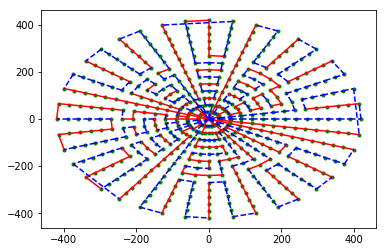

In [52]:
#MAXR = 1000
garb = 1
while (np.sum(sij)*garb !=0):
#if exteriorp == []:
    #maxij = np.unravel_index(np.argmax(c_sij), c_sij.shape)
    #sij[maxij[0], maxij[1]] = c_sij[maxij[0], maxij[1]]
    #c_sij[maxij[0], maxij[1]]
    #print('c_sij')
#else:
    maxij = np.unravel_index(np.argmax(sij), sij.shape)
    print(maxij, sij[maxij[0], maxij[1]])
    garb = sij[maxij[0], maxij[1]]
    if maxij[0] in allp and maxij[1] in allp:
        try:

            if maxij[0] in exteriorp and maxij[1] in exteriorp:
                print('Exterior')
                tempd = cij[0, maxij[0]] + cij[maxij[0],maxij[1]] + cij[maxij[1],0]
                if tempd <= MAXR:
                    tempc = demandL[n] - qi[maxij[0]] - qi[maxij[1]]
                    if tempc >= 0:
                        demandL[n]=tempc
                        distance[n] = tempd
                        pathroute[n].insert(-1, maxij[0])
                        pathroute[n].insert(-1, maxij[1])

                        sij[maxij[0], maxij[1]] = 0

                        connectedp.append(maxij[0])
                        connectedp.append(maxij[1])
                        exteriorp.remove(maxij[0])
                        exteriorp.remove(maxij[1])
                        depotp.append(maxij[0])
                        depotp.append(maxij[1])
                        n=n+1
                    else:
                        print('not feasible')

            elif maxij[0] in interiorp or maxij[1] in interiorp:
                print('Interior')
                sij[maxij[0], maxij[1]] = 0
            elif maxij[0] in depotp and maxij[1] in depotp:
                print('both connected to depot')
                if initCWSA == 1:
                    if exteriorp != []:
                        c_sij[maxij[0], maxij[1]] = sij[maxij[0], maxij[1]]
                        sij[maxij[0], maxij[1]] = 0
                        print('Skipped')

                # If same route then no!
                if locationlist(maxij[0])[0] == locationlist(maxij[1])[0]:
                    print('Same Route')
                    sij[maxij[0], maxij[1]] = 0
                # If different route then check if limit exceeds and join
                else:  
                    print('Different Route')

                    fromn = locationlist(maxij[0])[0]
                    ton = locationlist(maxij[1])[0]

                    temp1 = distance[fromn]
                    temp2 = distance[ton]

                    # Both CIS depot points
                    if pathroute[fromn][-2] == maxij[0] and pathroute[ton][-2] ==maxij[1]:
                        print('Cis depot - Outside')
                        trfrom = -1
                        trto = -1
                        transio = 0
                    elif pathroute[fromn][1] == maxij[0] and pathroute[ton][1]==maxij[1]:
                        print('Cis depot - Inside')
                        trfrom = 0
                        trto = 0
                        transio = 0
                    elif pathroute[fromn][1]==maxij[0] and pathroute[ton][-2]==maxij[1]:
                        print('trans - inside, outside')
                        trfrom = 0
                        trto = -1
                        transio = 1
                    elif pathroute[fromn][-2]==maxij[0] and pathroute[ton][1]==maxij[1]:
                        print('trans - outside, inside')
                        trfrom = -1
                        trto = 0
                        transio = 1
                    tempd = temp1 + temp2 + cij[maxij[0],maxij[1]] - cij[maxij[0],0] - cij[maxij[1],0]
                    tempc = MAXC - (MAXC - demandL[fromn] + MAXC - demandL[ton])

                    if tempc >=0:
                        if tempd <= MAXR:

                            demandL[ton] = tempc
                            del demandL[fromn]

                            distance[ton] = tempd
                            del distance[fromn]

                            del pathroute[fromn][trfrom]
                            del pathroute[ton][trto]

                            if transio == 0:
                                temppath = pathroute[ton] + pathroute[fromn][::-1]
                                if temppath[0] != 0 and temppath[-1]!=0:
                                    temppath = pathroute[fromn][::-1]+pathroute[ton]
                            elif transio == 1:
                                temppath = pathroute[ton] + pathroute[fromn]
                                if temppath[0] != 0 and temppath[-1]!=0:
                                    temppath = pathroute[fromn] + pathroute[ton]


                            pathroute[ton] = temppath
                            del pathroute[fromn]

                            sij[maxij[0]] = 0
                            sij[maxij[1]] = 0
                            sij[:,maxij[0]] = 0
                            sij[:,maxij[1]] = 0
                        else:
                            print('Max Route Length Reached')
                            sij[maxij[0], maxij[1]] = 0
                    else:
                        print('Max Capacity Reached')
                        sij[maxij[0], maxij[1]] = 0

            #elif maxij[0] in connectedp or maxij[1] in connectedp:
            elif maxij[0] in depotp or maxij[1] in depotp:

                print('one is depot')

                # Finding connected point
                if maxij[0] in depotp:
                    cp = maxij[0]
                    ncp = maxij[1]
                    print(cp, ncp)
                else:
                    cp = maxij[1]
                    ncp = maxij[0]
                    print(cp, ncp)
                ton, toi = locationlist(cp)

                tempd = distance[ton]
                print(tempd)

                if cp == pathroute[ton][1]:
                    print('interior')
                    d1 = pathroute[ton][1]
                    d2 = pathroute[ton][-2]
                elif cp == pathroute[ton][-2]:
                    print('exterior')
                    d1 = pathroute[ton][-2]
                    d2 = pathroute[ton][1]

                temp1 = tempd + cij[0,ncp] + cij[ncp, d1] - cij[d1,0]
                temp2 = tempd + cij[0,ncp] + cij[ncp, d2] - cij[d2,0]
                tempc = demandL[ton] - qi[ncp]

                if temp1-temp2<=1e-4:
                    tempd = temp1
                    cp = d1
                    op = d2
                    ton, toi =locationlist(cp)
                    print("depot point 1:", cp)

                else:
                    tempd = temp2
                    cp = d2
                    op = d1
                    print("depot point 2:", cp)

                    ton, toi = locationlist(cp)

                if pathroute[ton][-2]==cp:
                    #cp is at end
                    inserti = toi+1
                elif pathroute[ton][1]==cp:
                    inserti = toi

                if tempd <=MAXR and tempc>=0:
                    demandL[ton] = tempc
                    #print(ton, toi, ncp, pathroute)
                    distance[ton] = tempd
                    pathroute[ton].insert(inserti, ncp)

                    interiorp.append(cp)
                    depotp.remove(cp)
                    depotp.append(ncp)
                    sij[cp] = 0
                    sij[:,cp] = 0
                    sij[ncp, op] = 0 # same route
                    exteriorp.remove(ncp)
                    connectedp.append(ncp)
                else:
                    print('Max Capacity Reached')
                    sij[maxij[0], maxij[1]] = 0

            n = len(filterrm(pathroute))
        except ValueError:
            print("Does not exist")
        
print(n, np.sum(sij))
#exteriorp, interiorp, connectedp, depotp, pathroute, distance, sij
#print(*list(zip(demandL,MAXC - calcdemand(pathroute))), sep='\n')
sij
#print('Exterior points ->',exteriorp)
#print('\ninteriorp points ->',interiorp)
#print('\nconnectedp points ->',connectedp)
#print('\ndepotp points ->',depotp)
#print('\npathroute ->',pathroute)
#print('\nDistance ->',distance)
#print('\nSavings ->',sij)
ans = flagmap(pathroute)
plotroute(ans)
#print(filterrm(pathroute))
success(pathroute)

In [53]:
print(*list(zip(distance,routedistance(pathroute))), sep='\n')

(1797.7734765189734, 1797.773476518973)
(1793.0659307753024, 1793.0659307753024)
(1797.7734765189732, 1797.773476518973)
(1797.7734765189725, 1797.773476518973)
(1449.0752034870575, 1449.0752034870575)
(1489.4094818272397, 1489.4094818272404)
(1778.5743819590784, 1778.5743819590784)
(1120.2262211392149, 1120.2262211392147)
(1634.2923030854222, 1634.2923030854224)
(1797.4335885186888, 1797.4335885186886)
(870.4654423404246, 870.4654423404247)
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0], [0])
([0]

In [54]:
ans = flagmap(pathroute)

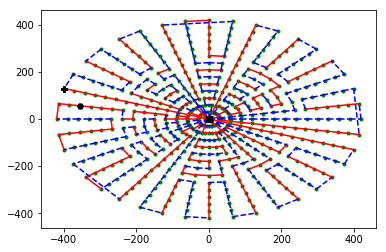

In [55]:
#plt.fig_size(20,15)
plotroute(ans)
#print(filterrm(pathroute))
plt.plot(0, 0, 'ks')
#plt.plot(xi, yi, lw = 0.5)
plt.plot(xi[460],yi[460],'kH', xi[539], yi[539],'kP')
#plt.xlim(-100,150)
#plt.ylim(-150,150)

In [56]:
UB = sum(routedistance(pathroute))
lamda, UB

(1.8, array([17326.]))

In [57]:
list(zip(list(zip(routedistance(pathroute), distance)),  list(zip(calcdemand(pathroute), demandL))))

[((1797.773476518973, 1797.7734765189734), (array([960.]), array([240.]))),
 ((1793.0659307753024, 1793.0659307753024), (array([1200.]), array([0.]))),
 ((1797.773476518973, 1797.7734765189732), (array([990.]), array([210.]))),
 ((1797.773476518973, 1797.7734765189725), (array([1190.]), array([10.]))),
 ((1449.0752034870575, 1449.0752034870575), (array([670.]), array([530.]))),
 ((1489.4094818272404, 1489.4094818272397), (array([1200.]), array([0.]))),
 ((1778.5743819590784, 1778.5743819590784), (array([1070.]), array([130.]))),
 ((1120.2262211392147, 1120.2262211392149), (array([920.]), array([280.]))),
 ((1634.2923030854224, 1634.2923030854222), (array([1130.]), array([70.]))),
 ((1797.4335885186886, 1797.4335885186888), (array([1180.]), array([20.]))),
 ((870.4654423404247, 870.4654423404246), (array([690.]), array([510.])))]

P 21
$\lamda$ =  1.8
40 x 14 : 560 Customers
Route Distance:  [17326.]
Best Known  16212.83


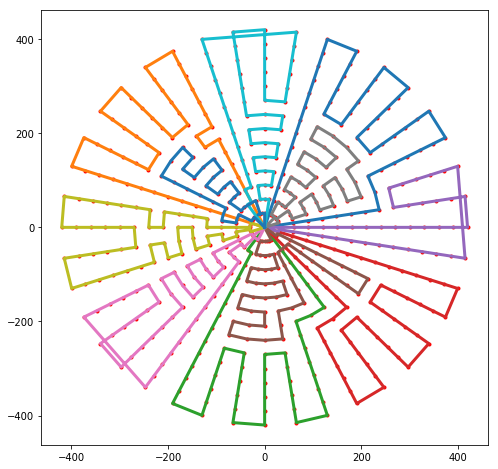

In [58]:
plt.figure(figsize = (8,8))
plotpath(pathroute)

## Solution Improvement

##### Deviation to Upper Bound

In [27]:
I = 30 # Improvement
UB = UB*0.01+UB
UB


array([17855.])

In [28]:
distance = (routedistance(pathroute))
BM = sum(distance)
BM

array([17678.])

In [29]:
# Nearest neighbor list
nlist = [[] for _ in range(cij.shape[0])]
nb = 40
cij
for i in range(0, cij.shape[0]):
        nlist[i] = list(np.argsort(cij[i][1:])[1:41])
        nlist[i] = list(np.array(nlist[i])+1)
#np.array(nlist[1]), cij[1]
print(np.array(nlist), sep = '\n')

[[ 20  18  30 ...  13   5  49]
 [  2  40   3 ...  28  14  15]
 [  3   1   4 ...  15  29  16]
 ...
 [518 478 559 ... 401 521 555]
 [519 479 558 ... 402 556 522]
 [520 480 559 ... 403 557 523]]


In [30]:
#i stands for initial
ipathroute = deepcopy(pathroute)
idemandL = deepcopy(demandL[:len(ipathroute)])
idistance = deepcopy(distance[:len(ipathroute)])
#list(zip(idemandL, idistance))
#pathroute


### Initializing Improvement

In [31]:
pathroute = deepcopy(ipathroute)
demandL = deepcopy(idemandL)
distance = deepcopy(idistance)
ni1 = 0
nj1 = 0
ni2 = 0
nj2 = 0
ni3 = 0
nj3 = 0

In [32]:
def onePM(routemap):
    '''One point move within routes'''
    improv = 0
    maxs = 1e-4 # temp saving
    ni = 0
    nj = 0 
    pr = len(routemap)+1
    for nodei in range(1, sij.shape[0]):
        for nodej in nlist[nodei]:
            routei, posi = locationlist(nodei)
            routej, posj = locationlist(nodej)
        
            njplus = routemap[routej][posj + 1]

            niplus = routemap[routei][posi + 1]
            nimin = routemap[routei][posi - 1]
            s = cij[nodej, njplus] + cij[nimin, nodei] + cij[nodei, niplus] -\
            (cij[nodei, nodej] + cij[nodei, njplus] + cij[nimin, niplus])    
            
            if routei == routej:
                "Same route"
                #tempdj = distance[routej] - s
                tempdj = pathdistance(pathroute[routej])
                tempc = demandL[routej]
                if tempdj<=MAXR:
                    
                    if abs(posi-posj)>1:

                        if s>=maxs:
                            tdj = tempdj
                            tc = tempc
                            maxs = s
                            ni = nodei
                            nj = nodej
                            pi = posi
                            pj = posj
                            imin = nimin
                            iplus = niplus
                            jplus = njplus
                            ri = routei
                            rj = routej
                            #print('One Point - Same Route|',maxs, ni, pi, ri,'|', nj, pj, rj)

                            improv = 1
                        
            elif routei != routej:
                "Different route"
                tempdi = distance[routei] - cij[nimin, nodei] - cij[nodei, niplus] + cij[nimin, niplus]
                tempdj = distance[routej] - cij[nodej, njplus] + cij[nodej, nodei] + cij[nodei, njplus]
                tempci = demandL[routei] - qi[nodei]
                tempcj = demandL[routej] + qi[nodei]
                if tempdi <=MAXR and tempdj<=MAXR and tempci>=0 and tempcj>=0:
                    if s>=maxs:
                        ni = nodei
                        nj = nodej
                        ri = routei
                        rj = routej
                        pi = posi
                        pj = posj
                        tdi = tempdi
                        tdj = tempdj
                        tci = tempci
                        tcj = tempcj
                        improv = 2
                else:
                    "Infeasible"
    if improv == 1:
   
            temppath = routemap[rj]
            del temppath[pi]
            temppath.insert(pj, ni)
            distance[rj] = pathdistance(temppath)
            demandL[rj] = tc
            
            #print(temppath)
            #print(nj, ni, iplus)
            print('One Point - Same Route|',maxs, ni, pi, ri,'|', nj, pj, rj)
            #print(imin, iplus, jplus)
    elif improv ==2:
        temppathi = routemap[ri]
        temppathj = routemap[rj]
        del temppathi[pi]
        temppathj.insert(pj+1,ni)
        print('One Point - Different Route|',maxs, ni, pi, ri,'|', nj, pj, rj)
        distance[ri]=tdi
        distance[rj]=tdj
        demandL[ri] = tci
        demandL[rj] = tcj
        print(temppathi, temppathj)
    
    else:
        print('No improvement - one point')
    return ni, nj

def twoPM(routemap):
    '''
    Exchange points i and j between routes
    '''
    improv = 0
    maxs = 1e-4
    ni = 0
    nj = 0
    ri = 0
    rj = 0
    for nodei in range(1, sij.shape[0]): # all points except 0 - depot
        for nodej in nlist[nodei]:
            #print(nodei, nodej)
            routei, posi = locationlist(nodei)
            routej, posj = locationlist(nodej)
            
            niplus = routemap[routei][posi + 1]
            nimin = routemap[routei][posi - 1]
            
            njplus = routemap[routej][posj + 1]
            njmin = routemap[routej][posj - 1]
            
            si1 = cij[nimin, nodei]+cij[nodei, niplus]
            sj1 = cij[njmin, nodej]+cij[nodej, njplus]
                
            si2 = cij[nimin, nodej]+cij[nodej, niplus]
            sj2 = cij[njmin, nodei]+cij[nodei, njplus]
                
            s = (si1+sj1)-(si2+sj2)
                
            if routei==routej:
                "Same Route"
                if abs(posi-posj)>1:
                    s = s
                else:
                    s = cij[nimin, nodei] + cij[nodej, njplus] - cij[nimin, nodej] - cij[nodei, njplus]
                    
                
                #tempd = distance[routei]-s
                tpath = deepcopy(routemap[routei])
                tpath[posi] = nodej
                tpath[posj] = nodei
                tempd = pathdistance(tpath)

                if tempd<=MAXR:
                    if s>maxs:
                        improv = 1
                        ri = routei
                        rj = routej
                        ni = nodei
                        nj = nodej
                        imin = nimin
                        iplus = niplus
                        jmin = njmin
                        jplus = njplus
                        pi = posi
                        pj = posj
                        td = tempd
                        #print(pi, pj)
                else:
                    'Infeasible'
                
            elif routei != routej:
                "Between Route"
                tempdi = distance[routei] - cij[nodei, nimin] - cij[nodei, niplus] + cij[nimin, nodej] + cij[nodej, niplus]
                tempdj = distance[routej] - cij[njmin, nodej] - cij[nodej, njplus] + cij[njmin, nodei] + cij[nodei, njplus]

                tempci = demandL[routei] - qi[nodei] + qi[nodej]
                tempcj = demandL[routej] - qi[nodej] + qi[nodei]
                
                if tempdi<=MAXR and tempdj <=MAXR:
                    if tempci>=0 and tempcj>=0:
                        if s>maxs:
                            #print(s)
                            maxs = s
                            ni = nodei
                            nj = nodej
                            imin = nimin
                            iplus = niplus
                            jmin = njmin
                            jplus = njplus
                            ri = routei
                            rj = routej
                            pi = posi
                            pj = posj
                            tdi = tempdi
                            tdj = tempdj
                            tci = tempci
                            tcj = tempcj
                            improv = 2

    if improv ==1:
        temppath = routemap[ri]
        temppath[pi] = nj
        temppath[pj] = ni
        distance[ri] = pathdistance(temppath)
        demandL[ri] = MAXC - demandpath(temppath)
        print('Two Point - Same Route|', ni, pi, ri, nj, pj, rj)
        print(temppath, pathdistance(temppath))
    
    elif improv == 2:
        
        pathi = routemap[ri]
        pathj = routemap[rj]
        distance[ri] = tdi
        distance[rj] = tdj
        demandL[ri] = tci
        demandL[rj] = tcj
        pathi[pi] = nj
        pathj[pj] = ni

        print('Two Point - Bet route|', ni, pi, ri,'|', nj, pj, rj)
        #print(pathi, pathj)
    else:
        print('No improvement - Two Point')
    return ni, nj

def twoopt(routemap):
    '''
    switch two points with another two within & Between routes
    '''
    improv = 0
    maxs = 1e-4
    ni = 0
    nj = 0
    ri = 0
    rj = 0
    for nodei in range(1, sij.shape[0]):
        for nodej in nlist[nodei]:
            routei, posi = locationlist(nodei)
            routej, posj = locationlist(nodej)
            #print(nodei, nodej)
            niplus = routemap[routei][posi + 1]
            nimin = routemap[routei][posi - 1]
            
            njplus = routemap[routej][posj + 1]
            njmin = routemap[routej][posj - 1]
             
            if routei == routej:
                "Same route"
                if abs(posi - posj)>2:
                    s1 = cij[nodei, niplus] + cij[nodej, njplus]
                    s2 = cij[nodei, nodej] + cij[niplus, njplus]
                    s = s1 - s2

                    tempdi = distance[routei] - s
                    tempci = demandL[routei] # same demand within route

                    if tempdi<=MAXR and tempci>=0:
                        "feasible"
                        if s>=maxs:
                            #print('Improvement - Same Route')
                            maxs=s
                            ni = nodei
                            nj = nodej
                            iplus = niplus # ineighbor
                            jplus = njplus #jneighbor
                            tdi = tempdi
                            tci = tempci
                            ri = routei
                            rj = routej
                            pi = posi
                            pj = posj
                            improv = 1
                    else:
                        "unfeasible"

                
            elif routei!= routej:
                "different route"

                s = cij[nodei, niplus] + cij[nodej, njplus] - cij[nodei, njplus] - cij[niplus, nodej]

                temppathi = deepcopy(routemap[routei])
                temppathj = deepcopy(routemap[routej])
                "i connects to j and i+1 connects to j+1"
                "0 - j comes to 0 - i => 0---i-j-----0"
                newpathi = temppathi[:posi+1]+temppathj[posj+1:]
                newpathj = temppathj[:posj+1]+temppathi[posi+1:]
                
                tempdi = pathdistance(newpathi)
                tempdj = pathdistance(newpathj)
                tempci = demandpath(newpathi)
                tempcj = demandpath(newpathj)
                
                if tempdi<=MAXR and tempdj<=MAXR and tempci<=MAXC and tempcj<=MAXC:
                    
                    if s>=maxs:
                        maxs = s
                        ni = nodei
                        nj = nodej
                        iplus = niplus
                        jplus = njplus
                        ri = routei
                        rj = routej
                        pi = posi
                        pj = posj
                        tdi = tempdi
                        tdj = tempdj
                        tci = tempci
                        tcj = tempcj
                        finalpathi = deepcopy(newpathi)
                        finalpathj = deepcopy(newpathj)
                        improv = 2

    if improv == 1:
        print('Two Opt - same route|',ni, ri, nj, rj)
        if pi<pj: # i before j
            temppath = deepcopy(routemap[ri])
        
            path1 = temppath[:pi+1]
            path2 = temppath[pi+1:pj+1]
            path3 = temppath[pj+1:]
            newpath = path1+path2[::-1]+path3
            routemap[ri] = deepcopy(newpath)
            distance[ri] = pathdistance(newpath)
            demandL[ri] = tci
            #print(path1, path2, path3, newpath)
        
            
    elif improv == 2:
        print('Two Opt - bet route|',ni, ri, nj, rj)
        #print(tempdi, tempdj)
        #print(finalpathi, finalpathj)
        routemap[ri] = deepcopy(finalpathi)
        routemap[rj] = deepcopy(finalpathj)
        distance[ri] = tdi
        distance[rj] = tdj
        demandL[ri] = MAXC - tci
        demandL[rj] = MAXC - tcj
        
    else:
        print('No improvement - Two Opt')
    
    return ni, nj
                

P 21
$\lamda$ =  1.8
40 x 14 : 560 Customers
Route Distance:  [17678.]
Best Known  16212.83
P 21
$\lamda$ =  1.8
40 x 14 : 560 Customers
Route Distance:  [17768.]
Best Known  16212.83
[17768.] [17678.] [17678.] [17768.]


(None,)

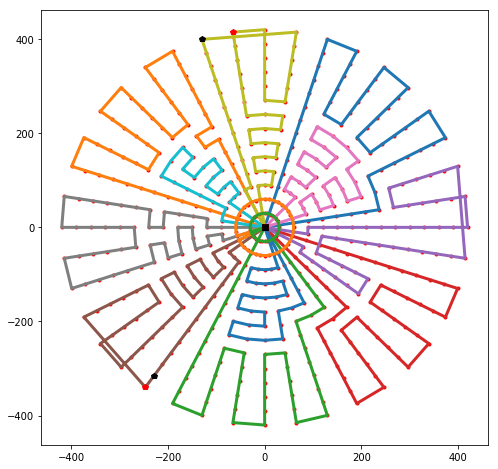

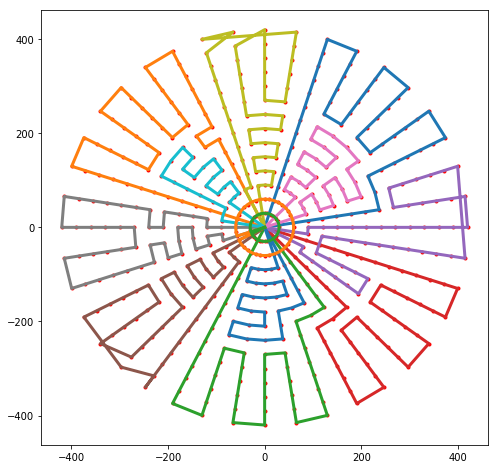

In [41]:
plt.figure(figsize = (8,8))
#plotroute(ans)
plotpath(ipathroute)
plt.plot(0, 0, 'ks')
plt.plot(xi[ni1], yi[ni1], 'rp', xi[nj1], yi[nj1], 'kp')
plt.plot(xi[ni2], yi[ni2], 'rp', xi[nj2], yi[nj2], 'kp')
plt.plot(xi[ni3], yi[ni3], 'rp', xi[nj3], yi[nj3], 'kp')
plt.figure(figsize = (8,8))
plotpath(pathroute)
print(sum(distance), sum(idistance), BM, sum(routedistance(pathroute))),# calcdemand(pathroute), routedistance(pathroute)

In [70]:
#i = 10
#j = 9
#I = 30

In [ ]:
#np.array(nlist[9])
#np.array(ipathroute[i]),np.array(ipathroute[j]), distance[i], pathdistance(pathroute[i]), distance[j],pathdistance(pathroute[j]), demandL[i],MAXC - demandpath(pathroute[i]), demandL[j],MAXC - demandpath(pathroute[j])

In [ ]:
#np.array(pathroute[i]), np.array(ipathroute[i]), pathdistance(pathroute[i]),pathdistance(ipathroute[i])

In [ ]:
#locationlist(ni1),locationlist(nj1), distance[3], pathdistance(pathroute[3])

### Improvement Loop

In [40]:
for I in range(1):    
    #ni1, nj1 = onePM(pathroute)
    ni2, nj2 = twoPM(pathroute)
    #ni3, nj3 = twoopt(pathroute)
    print('--------------',I+1,'---------------')
#locationlist(162)
#temppath
print('--------------Finish---------------')

Two Point - Same Route| 547 14 5 507 13 5
[0, 105, 106, 107, 147, 187, 227, 267, 307, 347, 387, 427, 467, 547, 507, 546, 544, 504, 464, 424, 384, 344, 345, 385, 425, 465, 505, 545, 506, 466, 426, 386, 346, 306, 305, 304, 264, 265, 266, 226, 225, 224, 184, 185, 186, 146, 145, 144, 104, 0] 1764.9457848051532
-------------- 1 ---------------
--------------Finish---------------


P 21
$\lamda$ =  1.8
40 x 14 : 560 Customers
Route Distance:  [17426.]
Best Known  16212.83
P 21
$\lamda$ =  1.8
40 x 14 : 560 Customers
Route Distance:  [17426.]
Best Known  16212.83
[17426.] [17426.] [17426.] [17426.]


(None,)

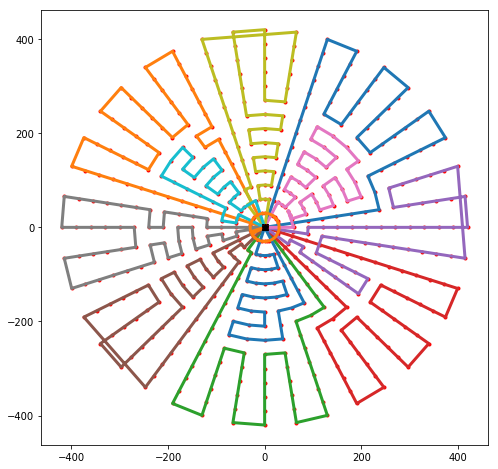

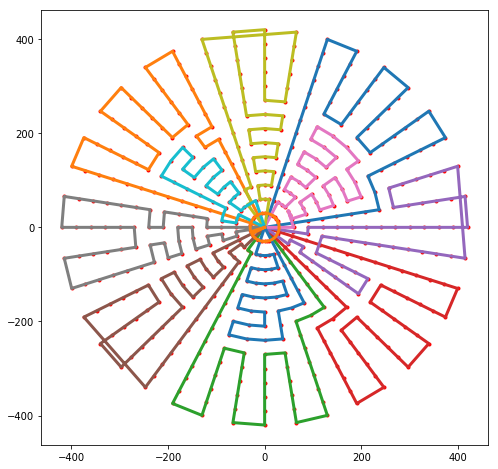

In [75]:
plt.figure(figsize = (8,8))
#plotroute(ans)
plotpath(ipathroute)
plt.plot(0, 0, 'ks')
plt.plot(xi[ni1], yi[ni1], 'rp', xi[nj1], yi[nj1], 'kp')
plt.plot(xi[ni2], yi[ni2], 'rp', xi[nj2], yi[nj2], 'kp')
plt.plot(xi[ni3], yi[ni3], 'rp', xi[nj3], yi[nj3], 'kp')
plt.figure(figsize = (8,8))
plotpath(pathroute)
print(sum(distance), sum(idistance), BM, sum(routedistance(pathroute))),# calcdemand(pathroute), routedistance(pathroute)

In [ ]:
list(zip(list(zip(routedistance(pathroute), distance)),  list(zip(MAXC - calcdemand(pathroute), demandL))))

In [ ]:
sum(distance), routedistance(pathroute)

In [ ]:
success(pathroute)

In [ ]:
locationlist(120)

In [ ]:
np.array(pathroute[2]), np.array(ipathroute[2])